In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [3]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf


import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

import root_pandas
%matplotlib inline

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

Welcome to JupyROOT 6.23/01


In [4]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [5]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [6]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

2.4.0
2.4.3


## Obtain datasets and simulations

In [7]:
path = '/Users/spaul/clas12/sidis_tuples/in/'
#data_electrons = root_pandas.read_root(path+'example_data_large.root', "electrons")
data_hadron = root_pandas.read_root(path+'example_data_large.root', "hadrons")

In [8]:
path = '/Users/spaul/clas12/sidis_tuples/in/'
#mc_electrons = root_pandas.read_root(path+'example_mc_large.root', "electrons")
mc_hadron = root_pandas.read_root(path+'mc_hadrons.root', "hadrons")

In [10]:
expr = "(E+.93827208816-sqrt(e_p**2+.000511**2)-sqrt(h_p**2+(abs(h_pid)==211)*.13957018**2+(abs(h_pid)==321)*.493677**2+(abs(h_pid)==2212)*.93827208816**2))**2"+\
       "-(E-e_p*cos(e_th)-h_p*cos(h_th))**2"+\
       "-(-e_p*sin(e_th)*cos(e_ph)-h_p*sin(h_th)*cos(h_ph))**2"+\
       "-(-e_p*sin(e_th)*sin(e_ph)-h_p*sin(h_th)*sin(h_ph))**2"
expr_truth = expr.replace("_","_truth_")
expr = "sqrt(abs(expr))*((expr>0)-2*(expr<0))".replace('expr',expr)
expr_truth = "sqrt(abs(expr))*((expr>0)-2*(expr<0))".replace('expr',expr_truth)

mc_hadron['missing_mass_truth']=mc_hadron.eval(expr_truth)
mc_hadron['missing_mass'] = mc_hadron.eval(expr)
data_hadron['missing_mass'] = data_hadron.eval(expr)

In [11]:

mc_hadron['pass_reco'] = np.where(mc_hadron['h_cm_pt']>0, 1, 0)
mc_hadron['pass_truth'] = np.where(mc_hadron['h_truth_cm_pt']*mc_hadron['Q2']>0, 1, 0)
data_hadron['pass_reco'] = np.where(data_hadron['h_cm_pt']>0, 1, 0)

In [12]:
#patch the things that are zero
for df in mc_hadron,:
    for column in df.columns:
        if "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_truth+(1-df.pass_truth)*-9999
        if not "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_reco+(1-df.pass_reco)*-9999



## Define cuts

In [13]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

def applyCutsHadron(df,isMC=False):
    temp = df
    #temp.eval('inelasticity = Nu/5.014', inplace=True)
    #temp.eval('E = sqrt(P*P+0.1396*0.1396)', inplace=True)
    #temp.eval('z = E/Nu',inplace=True)
    #temp= applyCut(temp, 'inelasticity<0.85','inelasticity < 0.85')
    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')
        temp = applyCut(temp,'abs(h_truth_pid)==211',' abs(mc_pid)=211')
        temp = applyCut(temp,'E>0','beam energy is nonzero')
        #temp.eval('mc_E = sqrt(mc_P*mc_P+0.1396*0.1396)', inplace=True)
        #temp.eval('mc_z = mc_E/mc_Nu',inplace=True)
    else:
        #temp = applyCut(temp, 'TargType==1', 'TargType==1')
        temp = applyCut(temp, 'abs(h_pid)==211','abs(h_pid)==211')

    return temp

## Apply cuts

In [14]:
print('Selecting MC events\n')
mc_hadron = applyCutsHadron(mc_hadron,isMC=True)
print('Selecting data events\n')
data_hadron= applyCutsHadron(data_hadron,isMC=False)

Selecting MC events

 pass_truth>0 13085989  fraction kept: 86.7
 abs(mc_pid)=211 6337798  fraction kept: 48.4
beam energy is nonzero 6337798  fraction kept: 100.0
Selecting data events

abs(h_pid)==211 3618896  fraction kept: 64.2


## Count the non zero pass_reco and pass_truth

In [15]:
data = data_hadron.sample(n=int(0.3e6))
mc   = mc_hadron#.sample(n=int(6e6))


## You want reasonable sample of MC,
## Try at minimum e.g x 3 the data size

In [16]:
print(len(data))
print(len(mc.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc)) ##only what is really reconstructed counts

300000
1018473
6337798


## Define inputs to the training. 

In [74]:

##Hadron momentum
Px_0_G = np.array(mc.eval("h_truth_p*sin(h_truth_th)*cos(h_truth_ph)"))
Px_0_S =np.array(mc.eval("h_p*sin(h_th)*cos(h_ph)"))
Px_unknown_S = np.array(data.eval("h_p*sin(h_th)*cos(h_ph)"))

Py_0_G = np.array(mc.eval("h_truth_p*sin(h_truth_th)*sin(h_truth_ph)"))
Py_0_S =np.array(mc.eval("h_p*sin(h_th)*sin(h_ph)"))
Py_unknown_S = np.array(data.eval("h_p*sin(h_th)*sin(h_ph)"))

Pz_0_G = np.array(mc.eval("h_truth_p*cos(h_truth_th)"))
Pz_0_S = np.array(mc.eval("h_p*cos(h_th)"))
Pz_unknown_S = np.array(data.eval("h_p*cos(h_th)"))

##Electron momentum
Ex_0_G = np.array(mc.eval("e_truth_p*sin(e_truth_th)*cos(e_truth_ph)"))
Ex_0_S =np.array(mc.eval("e_p*sin(e_th)*cos(e_ph)"))
Ex_unknown_S = np.array(data.eval("e_p*sin(e_th)*cos(e_ph)"))

Ey_0_G = np.array(mc.eval("e_truth_p*sin(e_truth_th)*sin(e_truth_ph)"))
Ey_0_S =np.array(mc.eval("e_p*sin(e_th)*sin(e_ph)"))
Ey_unknown_S = np.array(data.eval("e_p*sin(e_th)*sin(e_ph)"))

Ez_0_G = np.array(mc.eval("e_truth_p*cos(e_truth_th)"))
Ez_0_S = np.array(mc.eval("e_p*cos(e_th)"))
Ez_unknown_S = np.array(data.eval("e_p*cos(e_th)"))



Pid_0_G = np.array(mc['h_truth_pid'])
Pid_0_S = np.array(mc['h_pid'])
Pid_unknown_S = np.array(data['h_pid'])

Charge_0_G = (Pid_0_G>0)-2*(Pid_0_G<0)
Charge_0_S = (Pid_0_S>0)-2*(Pid_0_S<0)
Charge_unknown_S = (Pid_unknown_S>0)-2*(Pid_unknown_S<0)


Q2_0_G = np.array(mc.eval("4*E*e_truth_p*sin(e_truth_th/2)**2"))
Q2_0_S = np.array(mc['Q2'])
Q2_unknown_S = np.array(data['Q2'])

Nu_0_G = np.array(mc.eval("E-e_truth_p"))
Nu_0_S = np.array(mc['nu'])
Nu_unknown_S = np.array(data['nu'])

PhiPQ_0_G = np.array(mc['h_truth_cm_ph'])
PhiPQ_0_S = np.array(mc['h_cm_ph'])
PhiPQ_unknown_S = np.array(data['h_cm_ph'])

Zh_0_G = np.array(mc['h_truth_z'])
Zh_0_S =np.array(mc['z'])
Zh_unknown_S = np.array(data['z'])

W_0_G = np.array(mc.eval('sqrt((E+.93827208816-e_truth_p)**2-(E-e_truth_p*cos(e_truth_th))**2-(e_truth_p*sin(e_truth_th))**2)'))
W_0_S =np.array(mc['W'])
W_unknown_S = np.array(data['W'])


M_0_G = np.array(mc['missing_mass_truth'])
M_0_S = np.array(mc['missing_mass'])
M_unknown_S = np.array(data['missing_mass'])

Pt2_0_G = np.array(mc['h_truth_cm_pt'])
Pt2_0_S = np.array(mc['h_cm_pt'])
Pt2_unknown_S = np.array(data['h_cm_pt'])


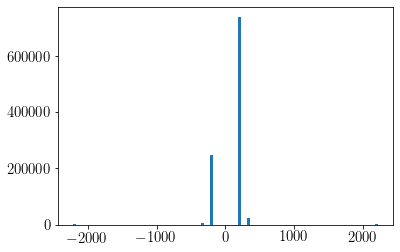

In [18]:
plt.hist(mc.query("pass_reco==1")["h_pid"],bins=100)
plt.show()

In [19]:
#theta0_G=np.c_[(Q2_0_G,Nu_0_G,PhiPQ_0_G,Pt2_0_G,Pid_0_G)]
#theta0_S=np.c_[(Q2_0_S,Nu_0_S,PhiPQ_0_S,Pt2_0_S,Pid_0_S)]
#theta_unknown_S=np.c_[(Q2_unknown_S,Nu_unknown_S,PhiPQ_unknown_S,Pt2_unknown_S,Pid_unknown_S)]

theta0_G=np.c_[(Zh_0_G,Pt2_0_G)]
theta0_S=np.c_[(Zh_0_S,Pt2_0_S)]
theta_unknown_S=np.c_[(Zh_unknown_S,Pt2_unknown_S)]



# OmniFold Gaussian Toy Example

## Setup the Datasets

In [20]:
#theta0_S[pass_reco==0][:,0] = -10
#theta0_G[pass_truth==0][:,0] = -10
#theta_unknown_S[:,0][data['pass_reco']!=0] = -10
#theta_unknown_G[:,0][data['pass_reco']!=0] = -10
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

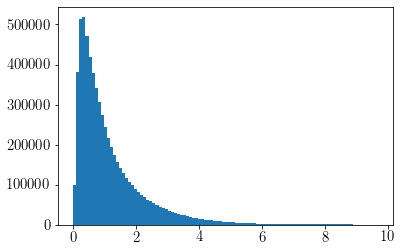

In [21]:
plt.hist(mc.h_truth_p,bins=100);plt.show()

<ipython-input-22-9c7f6bc62153>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-22-9c7f6bc62153>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


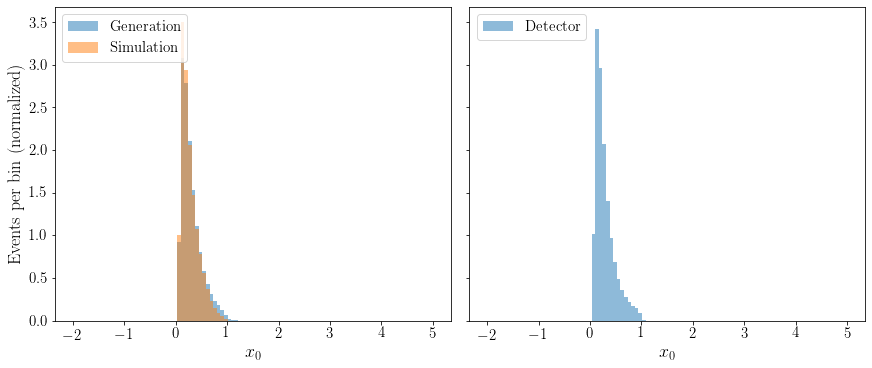

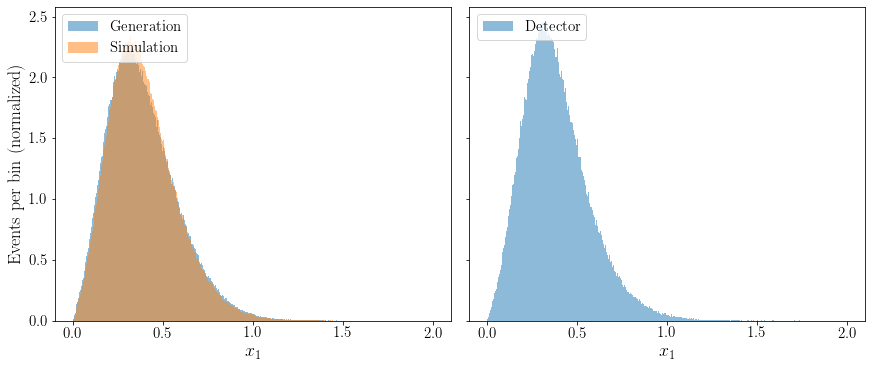

In [22]:
bins = np.linspace(-2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

#bins = np.linspace(-180,180, 101)
#bins = np.linspace(0,2, 101)
bins = np.linspace(0,2,400)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1],bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [23]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    #labels_unknown = np.ones(len(theta_unknown))
    
    #xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    #yvals_1 = np.concatenate((labels0, labels_unknown))
    #xvals_2 = np.concatenate((theta0_G, theta0_G))
    #yvals_2 = np.concatenate((labels0, labels_unknown))
    
    
    #theta0_G = np.stack(theta0_G, axis=1)
    #theta0_S = np.stack(theta0_S, axis=1)
    #theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    #labels0 = np.zeros(len(theta0_G))
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    # shape = (iteration, step, event)
    
    # initial iterative weights are ones

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

    

In [24]:
help(multifold)

Help on function multifold in module __main__:

multifold(num_observables, iterations, theta0_G, theta0_S, theta_unknown_S)



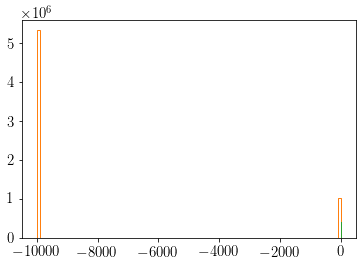

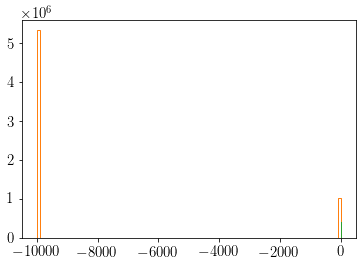

In [25]:
plt.hist(M_unknown_S,bins=100, histtype='step')
plt.hist(M_0_S,bins=100, histtype='step')
plt.hist(M_0_G,bins=100, histtype='step')
plt.show()
plt.hist(Q2_unknown_S,bins=100, histtype='step')
plt.hist(Q2_0_S,bins=100, histtype='step')
plt.hist(Q2_0_G,bins=100, histtype='step')
plt.show()

In [26]:
print(M_0_S)
print(W_0_S)

[ 2.73396788e+00 -9.99900000e+03 -9.99900000e+03 ...  1.48053904e+00
  1.90336047e+00 -9.99900000e+03]
[ 3.35352153e+00 -9.99900000e+03 -9.99900000e+03 ...  2.09439969e+00
  2.50427581e+00 -9.99900000e+03]


In [75]:
K.clear_session()
#theta0_G=np.c_[(Q2_0_G,Nu_0_G,PhiPQ_0_G,Pt2_0_G,Pid_0_G)]
#theta0_S=np.c_[(Q2_0_S,Nu_0_S,PhiPQ_0_S,Pt2_0_S,Pid_0_S)]
#theta_unknown_S=np.c_[(Q2_unknown_S,Nu_unknown_S,PhiPQ_unknown_S,Pt2_unknown_S,Pid_unknown_S)]

#theta0_G=np.c_[(Px_0_G,Py_0_G,Pz_0_G,Q2_0_G, Nu_0_G,PhiPQ_0_G,Zh_0_G)]
#theta0_S=np.c_[(Px_0_G,Py_0_G,Pz_0_G,Q2_0_S, Nu_0_S,PhiPQ_0_S,Zh_0_S)]
#theta_unknown_S=np.c_[(Px_unknown_S,Py_unknown_S,Pz_unknown_S, Q2_unknown_S,Nu_unknown_S,PhiPQ_unknown_S,Zh_unknown_S)]

num_observables = 8

theta0_G=np.c_[(Ex_0_G,Ey_0_G,Ez_0_G,Px_0_G,Py_0_G,Pz_0_G,M_0_G,Charge_0_G)]
theta0_S=np.c_[(Ex_0_S,Ey_0_S,Ez_0_S,Px_0_S,Py_0_S,Pz_0_S,M_0_S,Charge_0_S)]
theta_unknown_S=np.c_[(Ex_unknown_S,Ey_unknown_S,Ez_unknown_S,
                       Px_unknown_S,Py_unknown_S,Pz_unknown_S,M_unknown_S,Charge_unknown_S)]



pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

iterations = 4# use ~4 iterations   

import time,os
start = time.perf_counter()
try:
    weights, _ = multifold(num_observables=num_observables,
                           iterations=iterations,
                           theta0_G=theta0_G,
                           theta0_S=theta0_S,
                           theta_unknown_S= theta_unknown_S)

    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
    os.system('say "your program has finished"')
except Exception as e: 
    print(e)
    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
    os.system('say "your program has crashed"')


ITERATION: 1

STEP 1

Epoch 1/200
99/99 [==============================] - 31s 306ms/step - loss: 0.5426 - accuracy: 0.7717 - val_loss: 0.5348 - val_accuracy: 0.7728
Epoch 2/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5345 - accuracy: 0.7727 - val_loss: 0.5329 - val_accuracy: 0.7737
Epoch 3/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5335 - accuracy: 0.7729 - val_loss: 0.5323 - val_accuracy: 0.7741
Epoch 4/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5320 - accuracy: 0.7739 - val_loss: 0.5318 - val_accuracy: 0.7742
Epoch 5/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5319 - accuracy: 0.7737 - val_loss: 0.5313 - val_accuracy: 0.7743
Epoch 6/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5311 - accuracy: 0.7741 - val_loss: 0.5309 - val_accuracy: 0.7743
Epoch 7/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5307 - accuracy: 0.7741 - val_loss: 0.5311 - val_accu

99/99 [==============================] - 1s 8ms/step - loss: 0.5261 - accuracy: 0.7759 - val_loss: 0.5270 - val_accuracy: 0.7755
Epoch 59/200
99/99 [==============================] - 1s 8ms/step - loss: 0.5266 - accuracy: 0.7754 - val_loss: 0.5272 - val_accuracy: 0.7754
Epoch 60/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5267 - accuracy: 0.7754 - val_loss: 0.5274 - val_accuracy: 0.7753
Epoch 61/200
99/99 [==============================] - 1s 7ms/step - loss: 0.5270 - accuracy: 0.7752 - val_loss: 0.5272 - val_accuracy: 0.7754
Epoch 62/200
99/99 [==============================] - 1s 8ms/step - loss: 0.5272 - accuracy: 0.7749 - val_loss: 0.5271 - val_accuracy: 0.7755
Epoch 63/200
99/99 [==============================] - 1s 8ms/step - loss: 0.5273 - accuracy: 0.7748 - val_loss: 0.5269 - val_accuracy: 0.7755
Epoch 64/200
99/99 [==============================] - 1s 9ms/step - loss: 0.5263 - accuracy: 0.7755 - val_loss: 0.5274 - val_accuracy: 0.7754
Epoch 65/200
99/99 

<ipython-input-23-a083e389a88d>:78: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)



STEP 2

Epoch 1/200
951/951 [==============================] - 268s 282ms/step - loss: 0.6709 - accuracy: 0.5000 - val_loss: 0.6494 - val_accuracy: 0.4997
Epoch 2/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6495 - accuracy: 0.4999 - val_loss: 0.6489 - val_accuracy: 0.4997
Epoch 3/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6490 - accuracy: 0.5000 - val_loss: 0.6487 - val_accuracy: 0.4997
Epoch 4/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6488 - accuracy: 0.5002 - val_loss: 0.6485 - val_accuracy: 0.4996
Epoch 5/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6488 - accuracy: 0.5001 - val_loss: 0.6484 - val_accuracy: 0.4997
Epoch 6/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6486 - accuracy: 0.5000 - val_loss: 0.6491 - val_accuracy: 0.4996
Epoch 7/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6485 - accuracy: 0.5000 - val_loss: 0.6484 - val_acc

Epoch 58/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5006 - val_loss: 0.6465 - val_accuracy: 0.4986
Epoch 59/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5003 - val_loss: 0.6465 - val_accuracy: 0.4988
Epoch 60/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5003 - val_loss: 0.6465 - val_accuracy: 0.4989
Epoch 61/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6464 - accuracy: 0.5001 - val_loss: 0.6472 - val_accuracy: 0.4987
Epoch 62/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5000 - val_loss: 0.6467 - val_accuracy: 0.4986
Epoch 63/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5006 - val_loss: 0.6466 - val_accuracy: 0.4985
Epoch 64/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6465 - accuracy: 0.5005 - val_loss: 0.6464 - val_accuracy:

Epoch 115/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6461 - accuracy: 0.5003 - val_loss: 0.6463 - val_accuracy: 0.4991
Epoch 116/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6461 - accuracy: 0.5000 - val_loss: 0.6462 - val_accuracy: 0.4986
Epoch 117/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6462 - accuracy: 0.5005 - val_loss: 0.6462 - val_accuracy: 0.4984
Epoch 118/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6462 - accuracy: 0.5004 - val_loss: 0.6463 - val_accuracy: 0.4985
Epoch 119/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6461 - accuracy: 0.5000 - val_loss: 0.6462 - val_accuracy: 0.4984
Epoch 120/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6462 - accuracy: 0.5003 - val_loss: 0.6462 - val_accuracy: 0.4986
Epoch 121/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6461 - accuracy: 0.5000 - val_loss: 0.6462 - val_ac

99/99 [==============================] - 1s 6ms/step - loss: 0.4329 - accuracy: 0.7741 - val_loss: 0.4339 - val_accuracy: 0.7741
Epoch 34/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4328 - accuracy: 0.7743 - val_loss: 0.4339 - val_accuracy: 0.7737
Epoch 35/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4329 - accuracy: 0.7736 - val_loss: 0.4338 - val_accuracy: 0.7741
Epoch 36/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4323 - accuracy: 0.7746 - val_loss: 0.4340 - val_accuracy: 0.7730
Epoch 37/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4331 - accuracy: 0.7735 - val_loss: 0.4336 - val_accuracy: 0.7747
Epoch 38/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4324 - accuracy: 0.7748 - val_loss: 0.4338 - val_accuracy: 0.7751
Epoch 39/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4324 - accuracy: 0.7746 - val_loss: 0.4335 - val_accuracy: 0.7740
Epoch 40/200
99/99 

<ipython-input-23-a083e389a88d>:109: RuntimeWarning: overflow encountered in multiply
  weights_pull = weights_push * reweight(theta0_S)



STEP 2

Epoch 1/200
951/951 [==============================] - 262s 276ms/step - loss: 0.6827 - accuracy: 0.5002 - val_loss: 0.6488 - val_accuracy: 0.4995
Epoch 2/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6486 - accuracy: 0.5001 - val_loss: 0.6482 - val_accuracy: 0.4998
Epoch 3/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6481 - accuracy: 0.4999 - val_loss: 0.6477 - val_accuracy: 0.4996
Epoch 4/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6477 - accuracy: 0.5000 - val_loss: 0.6476 - val_accuracy: 0.4993
Epoch 5/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6476 - accuracy: 0.5003 - val_loss: 0.6474 - val_accuracy: 0.4997
Epoch 6/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6474 - accuracy: 0.5002 - val_loss: 0.6474 - val_accuracy: 0.4997
Epoch 7/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6473 - accuracy: 0.4997 - val_loss: 0.6472 - val_acc

Epoch 58/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6463 - accuracy: 0.5005 - val_loss: 0.6465 - val_accuracy: 0.4992
Epoch 59/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6463 - accuracy: 0.5002 - val_loss: 0.6465 - val_accuracy: 0.4989
Epoch 60/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6464 - accuracy: 0.5001 - val_loss: 0.6465 - val_accuracy: 0.4991
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping

ITERATION: 3

STEP 1

Epoch 1/200
99/99 [==============================] - 29s 288ms/step - loss: 0.4473 - accuracy: 0.7727 - val_loss: 0.4389 - val_accuracy: 0.7748
Epoch 2/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4391 - accuracy: 0.7734 - val_loss: 0.4373 - val_accuracy: 0.7746
Epoch 3/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4372 - accuracy: 0.7742 - val_loss: 0.4364 - val_accuracy: 0.7749
Epoch 4/200
99/99 [================

Epoch 55/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4315 - accuracy: 0.7754 - val_loss: 0.4321 - val_accuracy: 0.7761
Epoch 56/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4316 - accuracy: 0.7754 - val_loss: 0.4321 - val_accuracy: 0.7757
Epoch 57/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4321 - accuracy: 0.7747 - val_loss: 0.4323 - val_accuracy: 0.7756
Epoch 58/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4317 - accuracy: 0.7750 - val_loss: 0.4322 - val_accuracy: 0.7767
Epoch 59/200
99/99 [==============================] - 1s 9ms/step - loss: 0.4311 - accuracy: 0.7760 - val_loss: 0.4321 - val_accuracy: 0.7761
Epoch 60/200
99/99 [==============================] - 1s 8ms/step - loss: 0.4320 - accuracy: 0.7748 - val_loss: 0.4321 - val_accuracy: 0.7760
Epoch 61/200
99/99 [==============================] - 1s 8ms/step - loss: 0.4311 - accuracy: 0.7757 - val_loss: 0.4319 - val_accuracy: 0.7763
Epoch 

Epoch 20/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6474 - accuracy: 0.4998 - val_loss: 0.6476 - val_accuracy: 0.4999
Epoch 21/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6475 - accuracy: 0.4999 - val_loss: 0.6477 - val_accuracy: 0.5000
Epoch 22/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6473 - accuracy: 0.4998 - val_loss: 0.6476 - val_accuracy: 0.4995
Epoch 23/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6476 - accuracy: 0.4999 - val_loss: 0.6477 - val_accuracy: 0.4995
Epoch 24/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6479 - accuracy: 0.5001 - val_loss: 0.6476 - val_accuracy: 0.4994
Epoch 25/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6474 - accuracy: 0.5002 - val_loss: 0.6476 - val_accuracy: 0.5000
Epoch 26/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6472 - accuracy: 0.4999 - val_loss: 0.6476 - val_accuracy:

99/99 [==============================] - 1s 7ms/step - loss: 0.4352 - accuracy: 0.7735 - val_loss: 0.4360 - val_accuracy: 0.7731
Epoch 29/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4344 - accuracy: 0.7740 - val_loss: 0.4358 - val_accuracy: 0.7730
Epoch 30/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4336 - accuracy: 0.7749 - val_loss: 0.4361 - val_accuracy: 0.7725
Epoch 31/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4349 - accuracy: 0.7730 - val_loss: 0.4360 - val_accuracy: 0.7725
Epoch 32/200
99/99 [==============================] - 1s 7ms/step - loss: 0.4345 - accuracy: 0.7735 - val_loss: 0.4359 - val_accuracy: 0.7728
Epoch 33/200
99/99 [==============================] - 1s 8ms/step - loss: 0.4341 - accuracy: 0.7741 - val_loss: 0.4359 - val_accuracy: 0.7724
Epoch 34/200
99/99 [==============================] - 1s 8ms/step - loss: 0.4339 - accuracy: 0.7741 - val_loss: 0.4356 - val_accuracy: 0.7738
Epoch 35/200
99/99 

Epoch 17/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6471 - accuracy: 0.5002 - val_loss: 0.6472 - val_accuracy: 0.4998
Epoch 18/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6470 - accuracy: 0.4999 - val_loss: 0.6472 - val_accuracy: 0.4998
Epoch 19/200
951/951 [==============================] - 6s 7ms/step - loss: 0.6472 - accuracy: 0.5001 - val_loss: 0.6472 - val_accuracy: 0.4998
Epoch 20/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6470 - accuracy: 0.5000 - val_loss: 0.6472 - val_accuracy: 0.4999
Epoch 21/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6470 - accuracy: 0.4999 - val_loss: 0.6472 - val_accuracy: 0.4998
Epoch 22/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6470 - accuracy: 0.5001 - val_loss: 0.6472 - val_accuracy: 0.4998
Epoch 23/200
951/951 [==============================] - 6s 6ms/step - loss: 0.6470 - accuracy: 0.4997 - val_loss: 0.6471 - val_accuracy:

## Plot data and MC reweighted

In [76]:
## This is what in Ben's notebook. 
## The _S is RECO level. 
## You require that the RECO dataframe has a valid pass reco.
## The G is the truth level
## You required that the truth level has pass_truth valid.

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


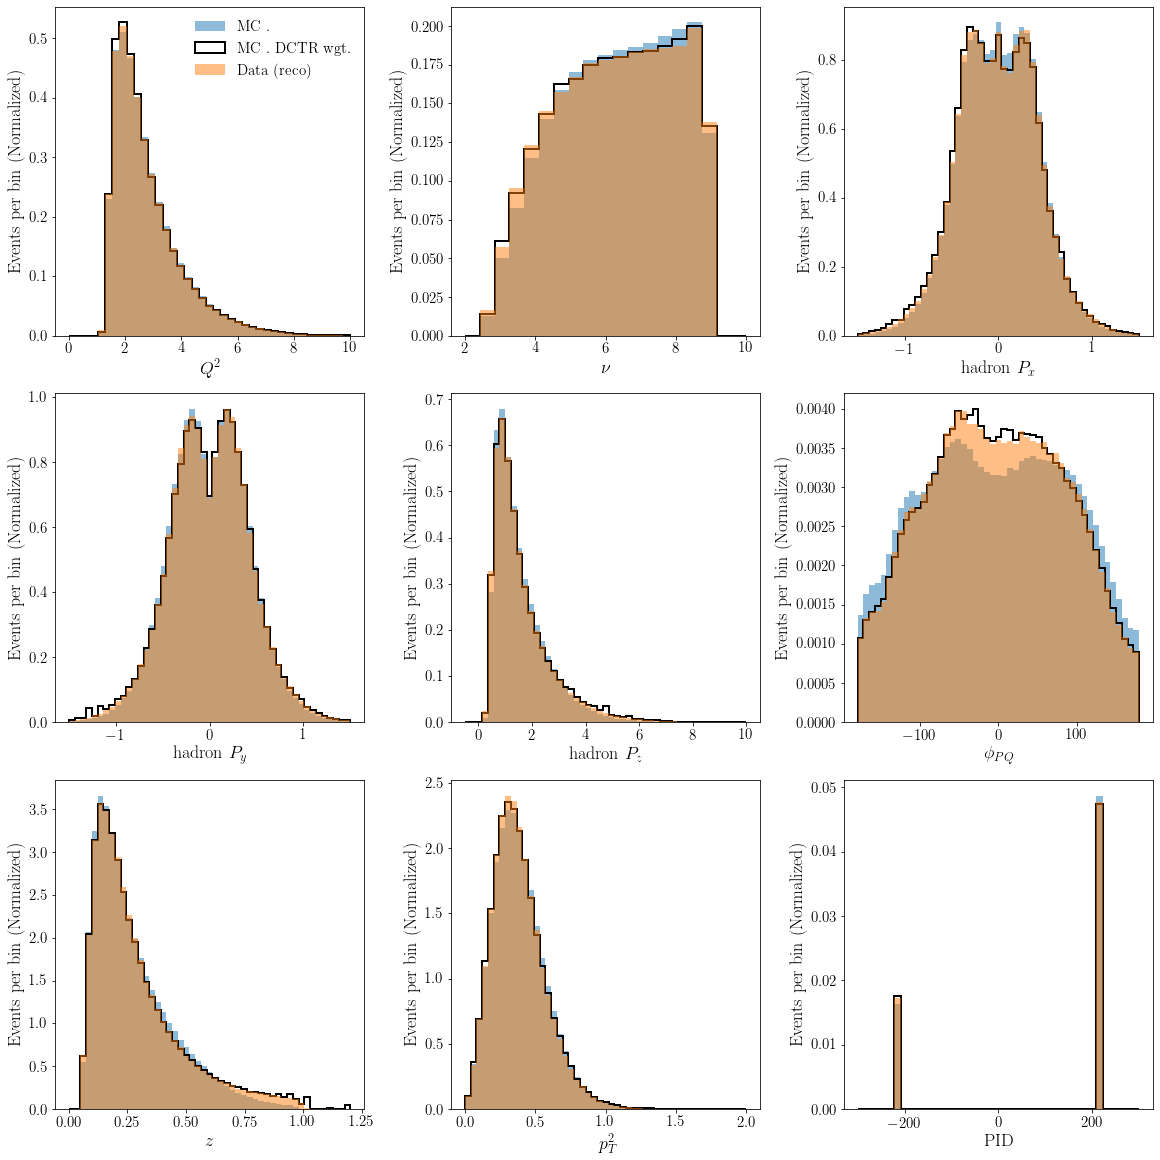

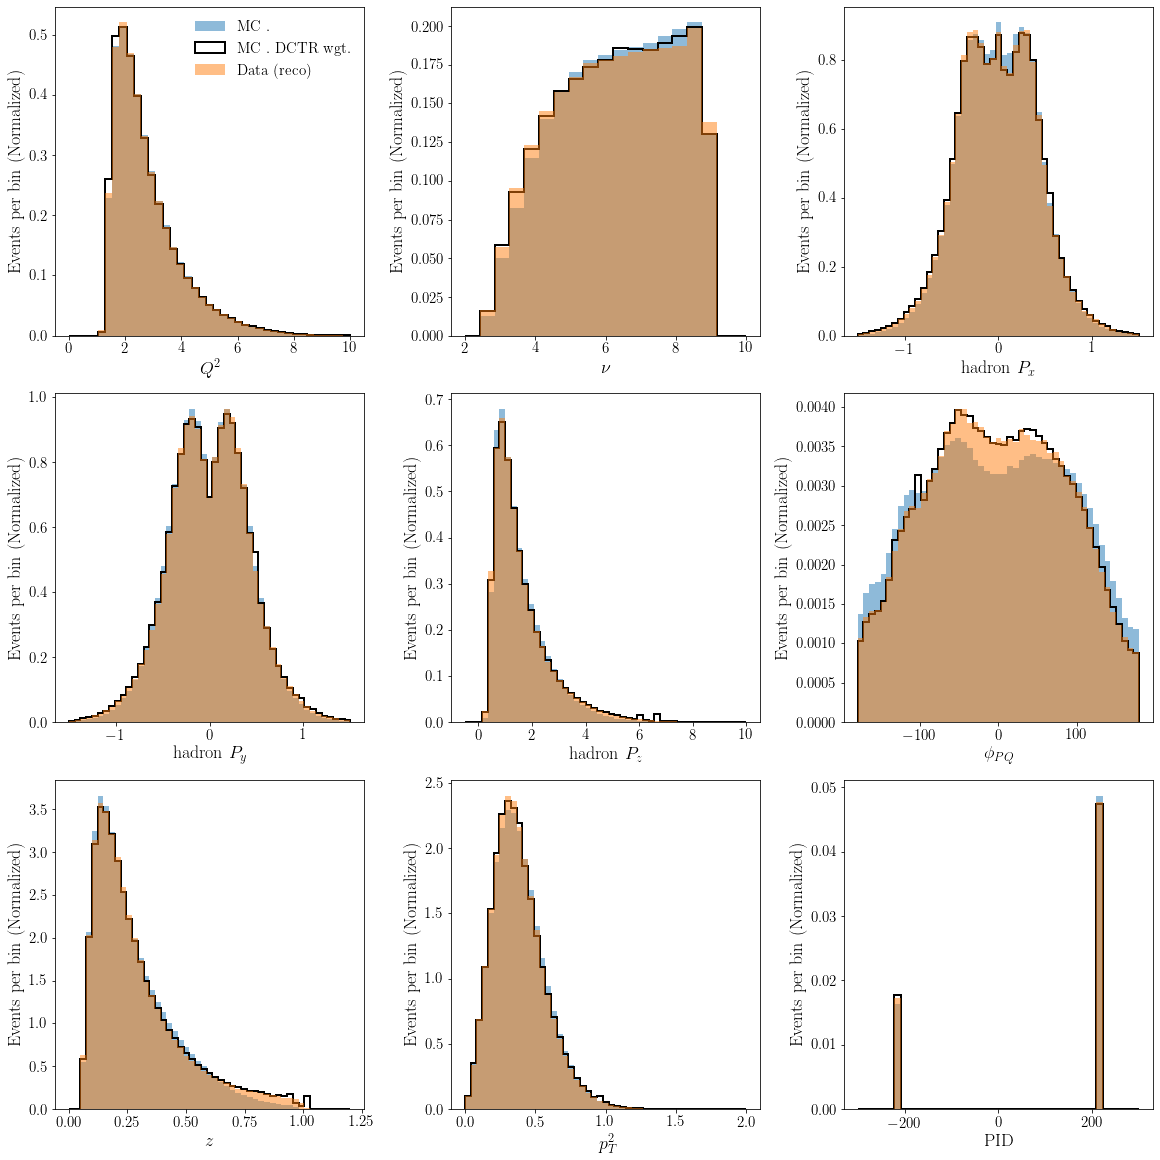

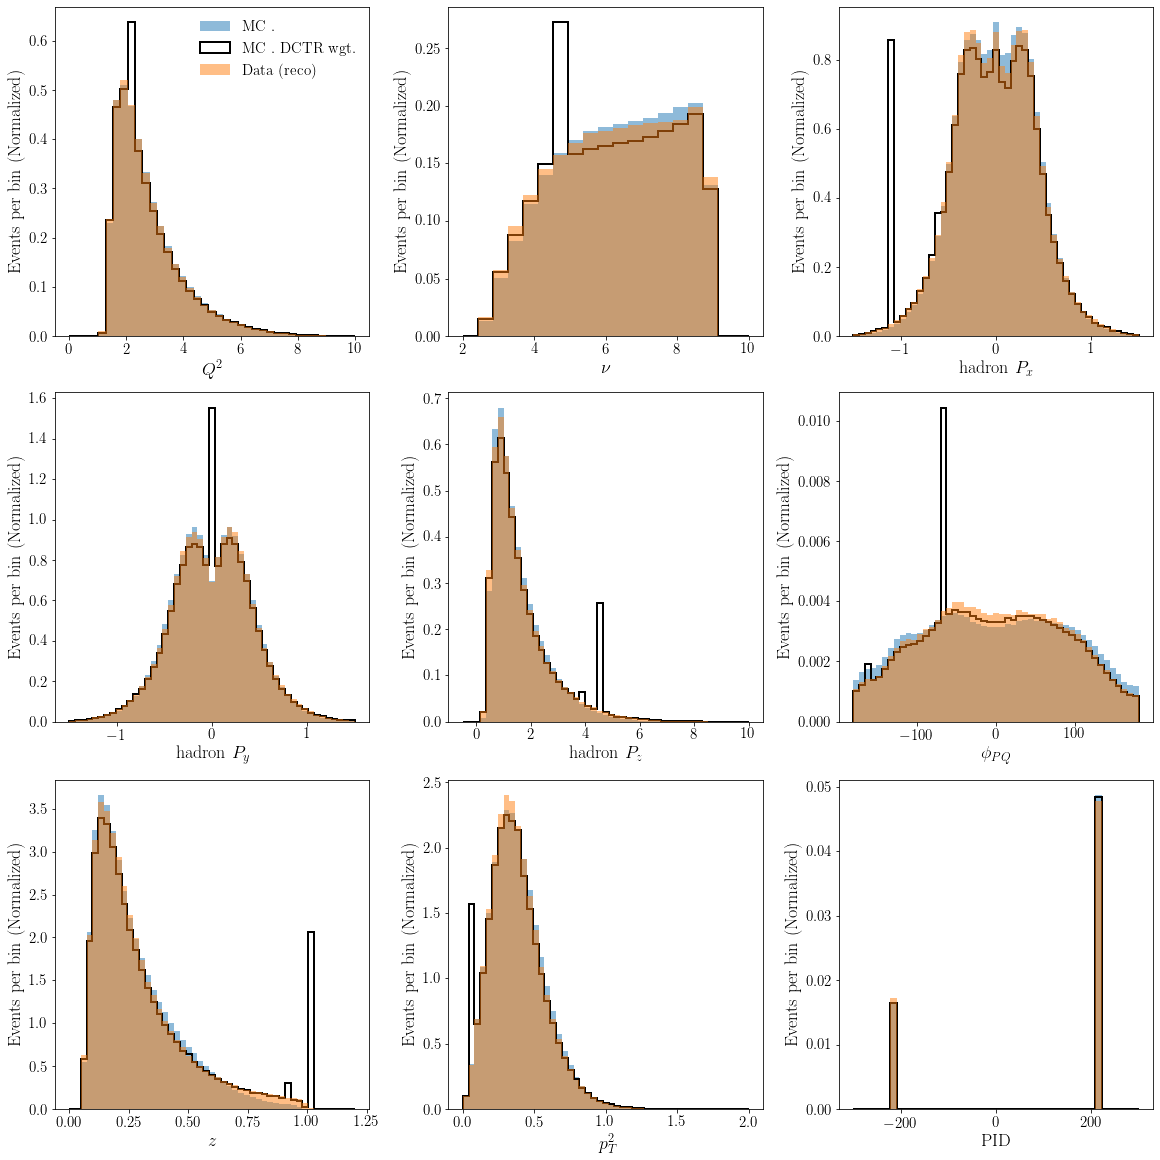

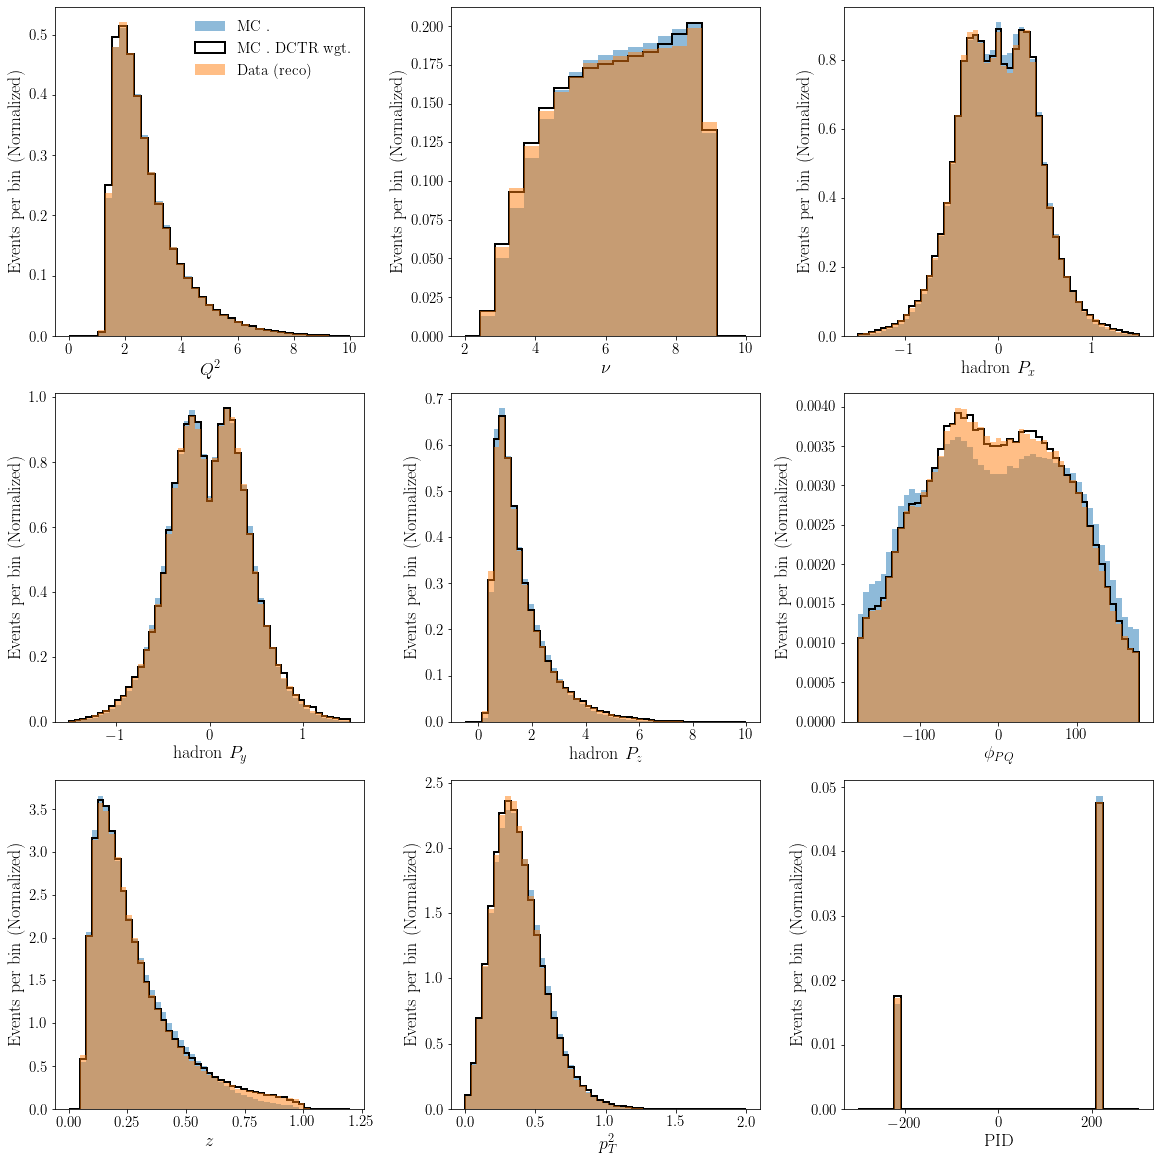

In [77]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, 10.0, 40)
    
    fig, ax = plt.subplots(3,
                           3,
                           figsize=(16, 16),
                           constrained_layout=True)
    ax[0,0].set_xlabel(r'$Q^{2}$')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(Q2_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[0,0].hist(Q2_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(Q2_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(2.0, 10, 20)

    ax[0,1].set_xlabel(r'$\nu$')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(Nu_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[0,1].hist(Nu_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[0,1].hist(Nu_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    
    
    bins = np.linspace(-1.5, 1.5, 50)

    ax[0,2].set_xlabel(r'hadron $P_{x}$')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(Px_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[0,2].hist(Px_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[0,2].hist(Px_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    
    bins = np.linspace(-1.5, 1.5, 50)

    ax[1,0].set_xlabel(r'hadron $P_{y}$')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(Py_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[1,0].hist(Py_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[1,0].hist(Py_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    bins = np.linspace(-0.5, 10.0, 50)

    ax[1,1].set_xlabel(r'hadron $P_{z}$')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(Pz_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[1,1].hist(Pz_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[1,1].hist(Pz_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    
    bins = np.linspace(-180, 180, 50)

    ax[1,2].set_xlabel(r'$\phi_{PQ}$')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(180/np.pi*PhiPQ_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[1,2].hist(180/np.pi*PhiPQ_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)
    
    ax[1,2].hist(180/np.pi*PhiPQ_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    bins = np.linspace(0, 1.2, 50)

    ax[2,0].set_xlabel(r'$z$')
    ax[2,0].set_ylabel('Events per bin (Normalized)')
    ax[2,0].hist(Zh_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[2,0].hist(Zh_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[2,0].hist(Zh_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    
    bins = np.linspace(0, 2, 50)

    ax[2,1].set_xlabel(r'$p_{T}^{2}$')
    ax[2,1].set_ylabel('Events per bin (Normalized)')
    ax[2,1].hist(Pt2_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[2,1].hist(Pt2_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[2,1].hist(Pt2_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    
    bins = np.linspace(-300, 300, 40)

    ax[2,2].set_xlabel('PID')
    ax[2,2].set_ylabel('Events per bin (Normalized)')
    ax[2,2].hist(Pid_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[2,2].hist(Pid_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[2,2].hist(Pid_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    fig.savefig("/Users/spaul/Downloads/reweighted.pdf")

## Put weights obtained with the DNN back into the mc dataframe:

In [78]:
mc['weight_reco'] = weights[-1, 0, :]
mc['weight_truth'] = weights[-1, 1, :]

## Transform dataframe back into ROOT file 

In [79]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

In [80]:
to_root(mc,'/Users/spaul/clas12/sidis_tuples/in/mc_hadrons_weighted7.root', key='ntuple_sim')


## Compute efficiency

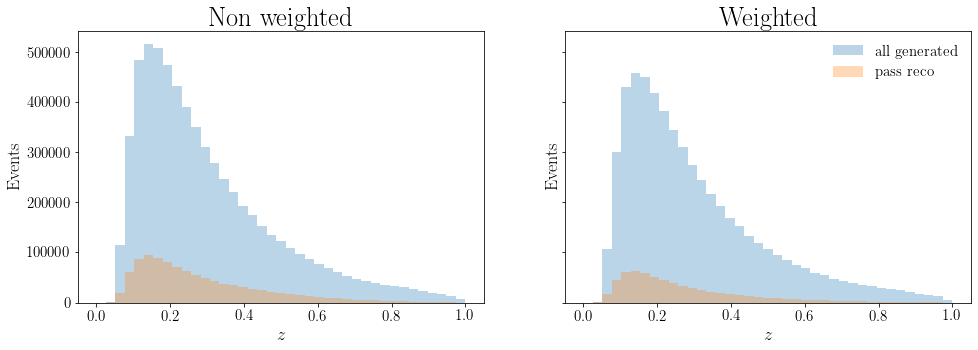

In [81]:
fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=True)

mask = np.logical_and(theta0_S[:,0]!=-10,theta0_G[:,0]!=-10)

bins = np.linspace(0,1.0,40)
axs[0].set_title('Non weighted')
axs[1].set_title('Weighted')
#axs[0].hist(Zh_0_G[theta0_S[:,0]==-10],alpha=0.3,bins=100, label='all generated')
axs[0].hist(Zh_0_G[theta0_G[:,0]!=-10],alpha=0.3,bins=bins, label='all generated')
axs[0].hist(Zh_0_G[mask], alpha=0.3,bins=bins, label='pass reco')
#axs[1].hist(Zh_0_G[theta0_S[:,0]==-10],alpha=0.3,bins=100,weights=weights[-1, 1, :][theta0_S[:,0]==-10],label='all generated')
axs[1].hist(Zh_0_G[theta0_G[:,0]!=-10],alpha=0.3,bins=bins,weights=weights[-1, 1, :][theta0_G[:,0]!=-10],label='all generated')
axs[1].hist(Zh_0_G[mask],alpha=0.3,bins=bins,weights=weights[-1, 1, :][mask],label='pass reco')


axs[0].set(xlabel=r"$z$", ylabel="Events")
axs[1].set(xlabel=r"$z$", ylabel="Events")
plt.legend()
plt.show()

[ True False False ...  True  True False]


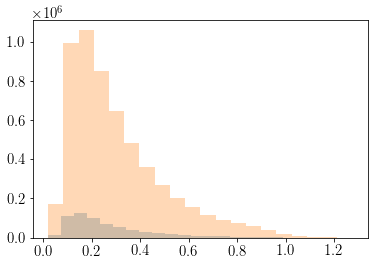

629415.2767924964
5608954.126093447
0.11221615699518563


In [82]:
#numerator
mask = np.logical_and(theta0_S[:,0]!=-10,theta0_G[:,0]!=-10)
print (mask) 
num,x,_  = plt.hist(Zh_0_G[mask], weights=weights[-1, 1, :][mask],bins=20,label='numerator, weighted',alpha=0.3)
den,x,_ = plt.hist(Zh_0_G[theta0_G[:,0]!=-10], weights=weights[-1, 1, :][theta0_G[:,0]!=-10],bins=20,label='numerator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

#plt.hist(theta0_G[theta0_S[:,0]!=-10][:,1])
plt.show()
eff_weighted= np.true_divide(num,den)
print(sum(num))
print(sum(den))
print(sum(num)/sum(den))
#plt.legend()

## Plot efficiency with no weighting (i.e. out of the box MC)

[ True False False ...  True  True False]


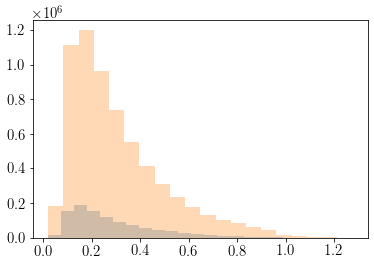

1018473.0
6337798.0
0.16069824251262033


In [83]:
#numerator
mask = np.logical_and(theta0_S[:,0]!=-10,theta0_G[:,0]!=-10)
print (mask) 
num,x,_  = plt.hist(Zh_0_G[mask], bins=20,label='numerator, weighted',alpha=0.3)
den,x,_ = plt.hist(Zh_0_G[theta0_G[:,0]!=-10], bins=20,label='numerator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

#plt.hist(theta0_G[theta0_S[:,0]!=-10][:,1])
plt.show()
eff= np.true_divide(num,den)
print(sum(num))
print(sum(den))
print(sum(num)/sum(den))
#plt.legend()

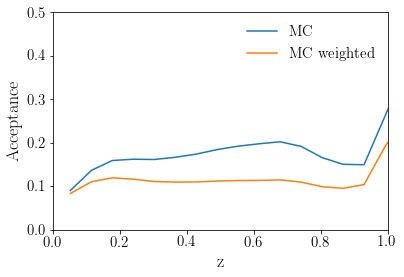

In [84]:
plt.plot(x,eff,label='MC')
plt.plot(x,eff_weighted, label='MC weighted')

plt.ylabel('Acceptance')
plt.xlabel('z')
plt.legend(loc='best',frameon=False)
plt.ylim([0.,0.5])
plt.xlim([0.,1.0])
plt.xlabel("z")
fig.savefig("../images/efficiency_weighted_z.pdf")

In [85]:
#numerator
mask = np.logical_and(theta0_S[:,0]!=-10,theta0_G[:,0]!=-10)
print (mask) 


def eff_plot(truthvar,mn,mx,bins=20,query=None):
    a = np.array(mc_hadron.eval(truthvar))
    if(query!= None):
        mask1 = np.logical_and(mask,mc_hadron.eval(query))
        mask2 = np.logical_and(theta0_G[:,0]!=-10,mc_hadron.eval(query))
    else :
        mask1 = mask
        mask2 = theta0_G[:,0]!=-10
    num,x  = np.histogram(a[mask1],range=(mn,mx), bins=bins)
    den,x = np.histogram(a[mask2],range=(mn,mx), bins=bins)
    x= (x[1:] + x[:-1])/2.0

    #plt.hist(theta0_G[theta0_S[:,0]!=-10][:,1])
    
    eff= np.true_divide(num,den)
    deff = np.sqrt((num*(den-num))/(den+(den<=0))**3)
    
    num,x  = np.histogram(a[mask1], weights=weights[-1, 1, :][mask1],range=(mn,mx),bins=bins)
    den,x  = np.histogram(a[mask2], weights=weights[-1, 1, :][mask2],range=(mn,mx),bins=bins)
    x= (x[1:] + x[:-1])/2.0

    #plt.hist(theta0_G[theta0_S[:,0]!=-10][:,1])
    #plt.show()
    eff_weighted= np.true_divide(num,den)
    

    #plt.plot(x,eff,label='MC')
    #plt.plot(x,eff_weighted, label='MC weighted')
    plt.errorbar(x,eff,deff,label='MC',marker='o',color='k',linestyle='',)
    plt.errorbar(x+0.2*(x[1]-x[0]),eff_weighted,deff, label='MC weighted',marker='o',linestyle='',color='r')

    



[ True False False ...  True  True False]


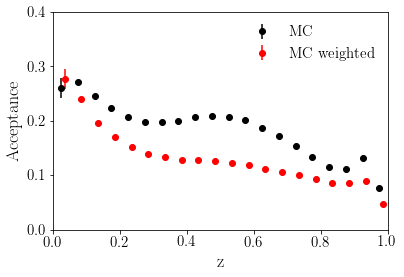

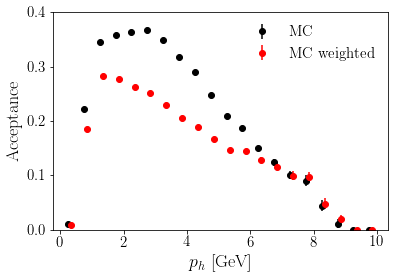

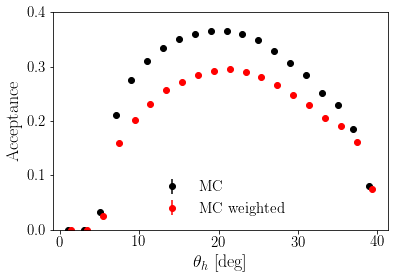

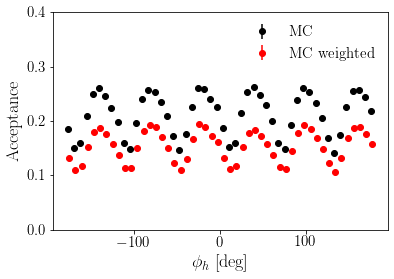

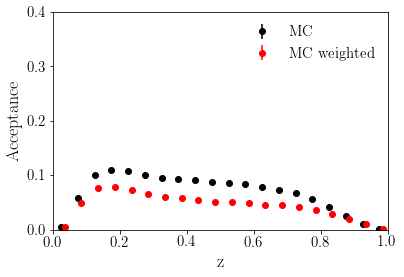

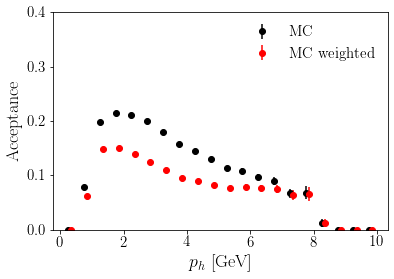

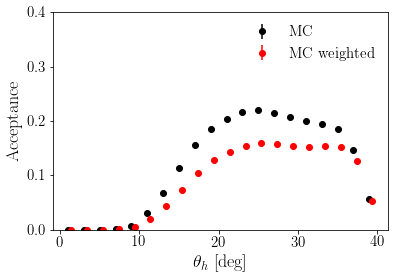

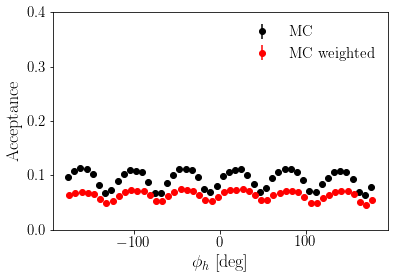

In [86]:
for pid in 211, -211:
    query = "h_truth_pid == %s"%pid
    eff_plot("h_truth_z",0,1,query=query)
    plt.ylabel('Acceptance')
    plt.xlabel('z')
    plt.legend(loc='best',frameon=False)
    plt.ylim([0.,0.4])
    plt.xlim([0.,1.0])
    plt.xlabel("z")
    plt.savefig("../images/efficiency_weighted_z_%s.pdf"%pid,bbox_inches='tight')
    plt.show()

    eff_plot("h_truth_p",0,10,query=query)
    plt.ylabel('Acceptance')
    plt.xlabel('$p_h$ [GeV]')
    plt.legend(loc='best',frameon=False)
    plt.gca().set_ylim(0,0.4)
    plt.savefig("../images/efficiency_weighted_hp_%s.pdf"%pid,bbox_inches='tight')
    plt.show()

    eff_plot("h_truth_th*180/3.14159",0,40,query=query)
    plt.ylabel('Acceptance')
    plt.xlabel('$\\theta_h$ [deg]')
    plt.legend(loc='best',frameon=False)
    plt.gca().set_ylim(0,0.4)
    plt.savefig("../images/efficiency_weighted_hth_%s.pdf"%pid,bbox_inches='tight')
    plt.show()

    eff_plot("h_truth_ph*180/3.14159",-180,180,bins=50,query=query)
    plt.ylabel('Acceptance')
    plt.xlabel('$\\phi_h$ [deg]')
    plt.legend(loc='best',frameon=False)
    plt.gca().set_ylim(0,0.4)
    plt.savefig("../images/efficiency_weighted_hph_%s.pdf"%pid,bbox_inches='tight')
    plt.show()

In [87]:
##Plot the unfolded distributions

ITERATION 1:


No handles with labels found to put in legend.


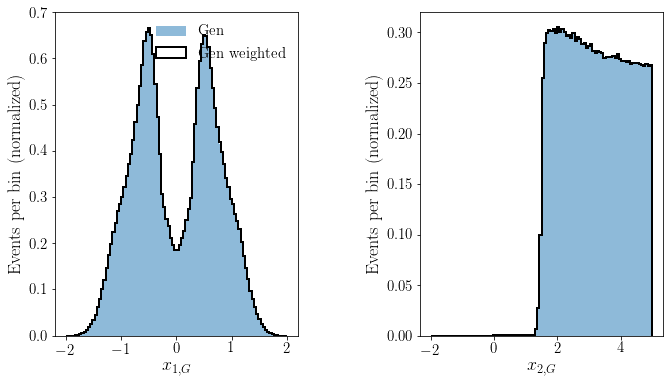

In [88]:
bins = np.linspace(-2, 2, 101)

for i in range(1):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(10, 5))
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    
    gs = plt.GridSpec(1, 2)
    gs.update(left=0.08, right=0.925,
              top=0.95, bottom=0.05,
              hspace=0.3, wspace=0.5)

    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])     
    
    hist0 = ax1.hist(theta0_G[theta0_G[:,0]!=-10][:,0],
                     bins=bins,
                     **plot_style_2,label='Gen')

    hist1 = ax1.hist(
        theta0_G[theta0_G[:,0]!=-10][:,0],
        bins=bins,
        label='Gen weighted',
        weights=weights[i, 1, :][theta0_G[:,0]!=-10],
        **plot_style_1)

    ax1.legend(frameon=False)
    ax1.set(xlabel=r"$x_{1,G}$", ylabel="Events per bin (normalized)")
    #ax1.set_ylim([0,0.6])
    bins = np.linspace(-2, 5, 101)

    hist0 = ax2.hist(theta0_G[theta0_G[:,0]!=-10][:,2],
                     bins=bins,
                     **plot_style_2)

    hist1 = ax2.hist(
        theta0_G[theta0_G[:,0]!=-10][:,2],
        bins=bins,
        weights=weights[i, 1, :][theta0_G[:,0]!=-10],
        **plot_style_1)

    ax2.legend(frameon=False)
    ax2.set(xlabel=r"$x_{2,G}$", ylabel="Events per bin (normalized)")
    #ax2.set_ylim([0,0.6])

In [89]:
def weight_plot(query, expr, mn,mx,bins):
    binning = np.linspace(mn, mx, bins)
    
    plt.hist(mc.query(query).eval(expr),density=True,bins=binning,alpha=0.5,label='mc')
    plt.hist(mc.query(query).eval(expr),bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_2,label='mc weighted')
    plt.hist(data.query(query).eval(expr),bins=binning,label='data',**plot_style_1)
    
    y,binEdges = np.histogram(data.query(query).eval(expr),bins=binning)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    dy     = np.sqrt(y)
    width      = (binning[1]-binning[0])
    norm =sum(y)/len(y)*(binning[-1]-binning[0])
    y=y/norm
    dy/= norm
    plt.errorbar(bincenters, y, dy,color='k',linestyle='')

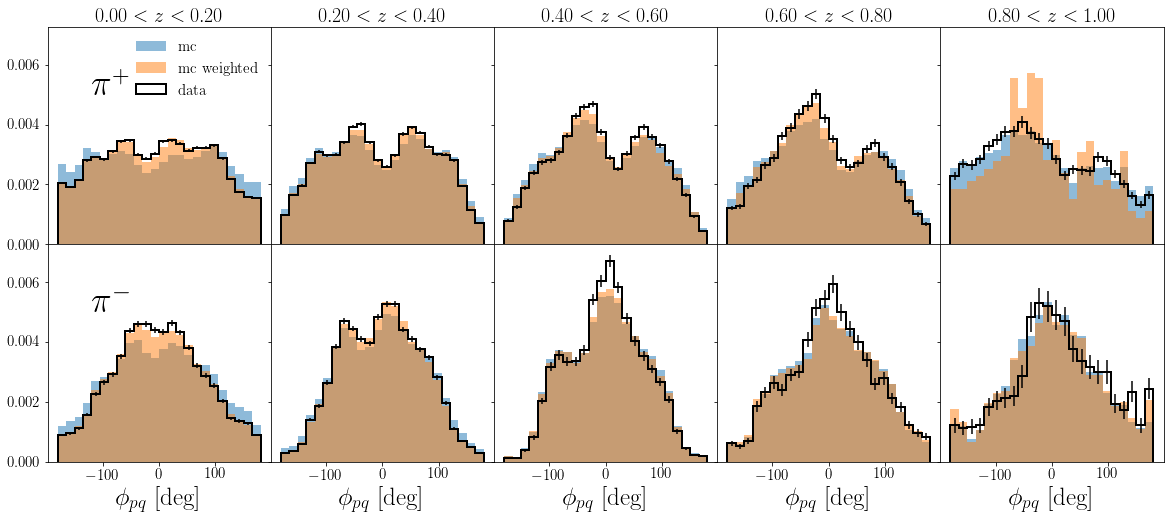

In [90]:
fig, axs = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20,8), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for i,pm,pid in (0,'+',211),(1,'-',-211):
    for j, ibin in enumerate(bins):
        plt.sca(axs[i][j])
        weight_plot('z>%2.2f and z<%2.2f and h_pid==%s'%(ibin[0],ibin[1],pid),'h_cm_ph*180/3.141592',-180,180,25)
        if j == 0:
            axs[i][j].text(-120, 0.005, "$\\pi^%s$"%pm, fontsize=35)
        if i == 0:
            axs[i][j].set_title('$%2.2f<z<%2.2f$'%(ibin[0],ibin[1]),fontsize=20)
        else:
            axs[i][j].set_xlabel(r'$\phi_{pq}$ [deg]',fontsize=25)
        
#axs[j].set_yscale('log')
axs[0][0].legend(frameon=False,loc='best')
fig.savefig("../images/phipq.pdf")

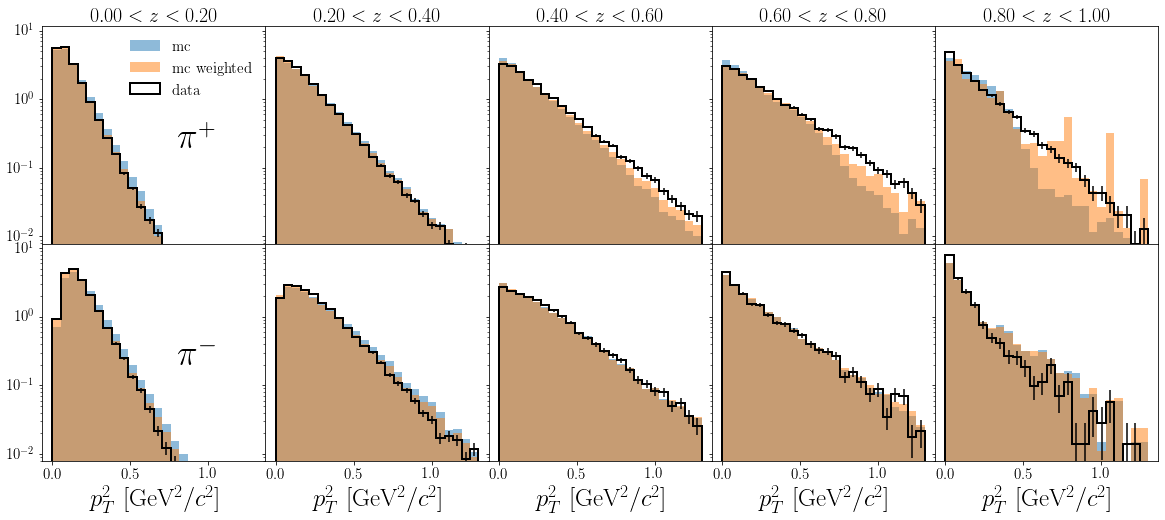

In [91]:
fig, axs = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20,8), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for i,pm,pid in (0,'+',211),(1,'-',-211):
    for j, ibin in enumerate(bins):
        plt.sca(axs[i][j])
        weight_plot('z>%2.2f and z<%2.2f and h_pid==%s'%(ibin[0],ibin[1],pid),'h_cm_pt**2',0,1.3,25)
        if j == 0:
            axs[i][j].text(0.8, 0.2, "$\\pi^%s$"%pm, fontsize=35)
        if i == 0:
            axs[i][j].set_title('$%2.2f<z<%2.2f$'%(ibin[0],ibin[1]),fontsize=20)
        else:
            axs[i][j].set_xlabel(r'$p_{T}^2$  [GeV$^2/c^2$]',fontsize=25)
        axs[i][j].set_yscale('log')
#axs[j].set_yscale('log')
axs[0][0].legend(frameon=False,loc='best')
fig.savefig("../images/pt.pdf")

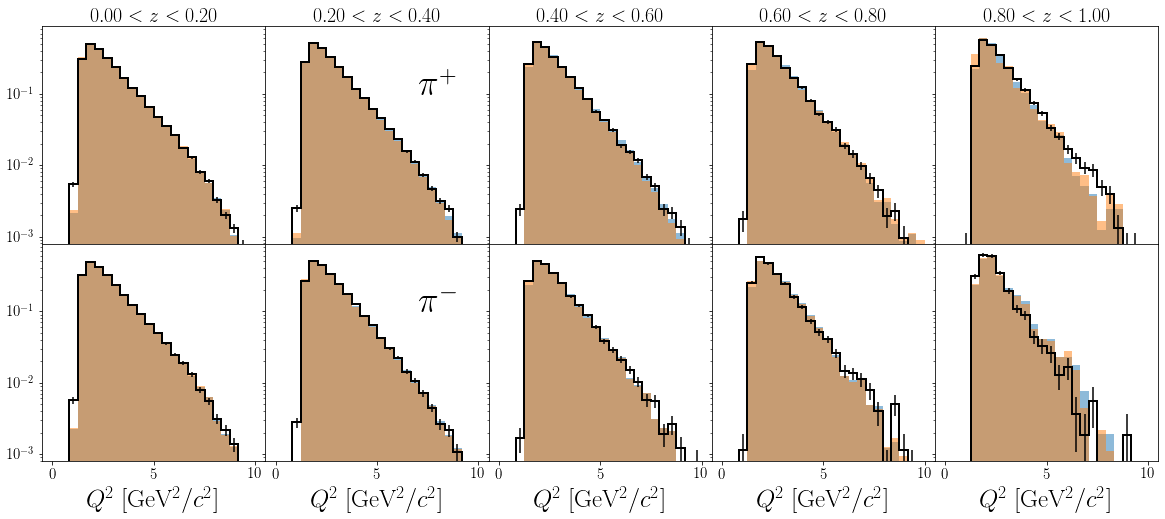

In [92]:
fig, axs = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20,8), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for i,pm,pid in (0,'+',211),(1,'-',-211):
    for j, ibin in enumerate(bins):
        plt.sca(axs[i][j])
        weight_plot('z>%2.2f and z<%2.2f and h_pid==%s'%(ibin[0],ibin[1],pid),'Q2',0,10,25)
        if j == 1:
            axs[i][j].text(7, 0.1, "$\\pi^%s$"%pm, fontsize=35)
        if i == 0:
            axs[i][j].set_title('$%2.2f<z<%2.2f$'%(ibin[0],ibin[1]),fontsize=20)
        else:
            axs[i][j].set_xlabel(r'$Q^2$ [GeV$^2/c^2$]',fontsize=25)
        axs[i][j].set_yscale('log')
#axs[j].set_yscale('log')

fig.savefig("../images/Q2.pdf")

h_truth_pid == -211
h_truth_pid == -211


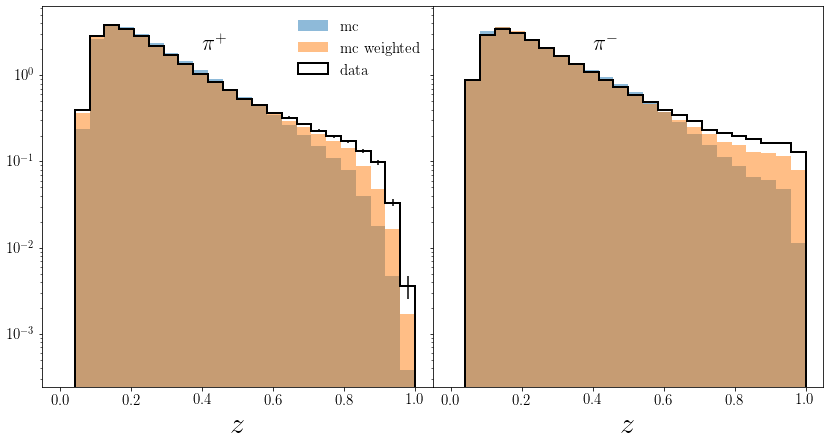

In [93]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14,7), gridspec_kw={'hspace': 0, 'wspace':0})


for j, charge in enumerate([-211,211]):
    plt.sca(axs[j])
    weight_plot('h_pid==%s'%(charge),'z',0,1,25)
    
    axs[j].set_xlabel(r'$z$',fontsize=30)
    axs[j].set_yscale('log')
    print(query)
axs[0].legend(frameon=False,loc='best')
axs[0].text(0.4, 2,"$\\pi^+$")
axs[1].text(0.4, 2,"$\\pi^-$")
fig.savefig("../images/z.pdf")

h_truth_pid == -211
h_truth_pid == -211


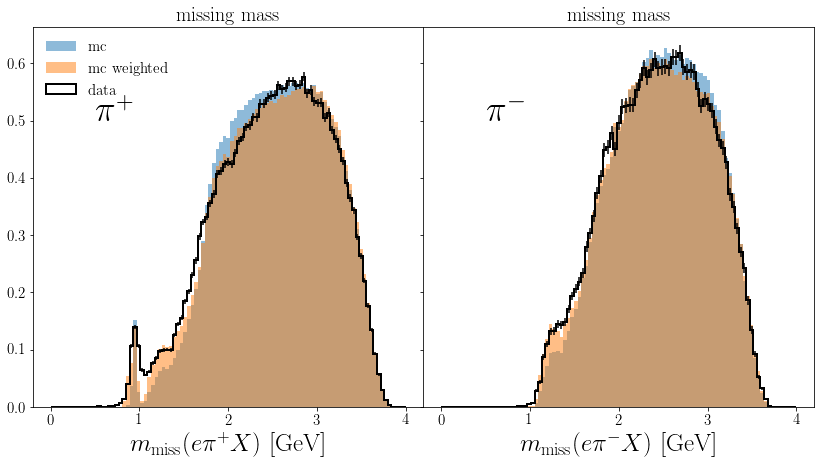

In [94]:
expr = "sqrt((E+.93827208816-sqrt(e_p**2+.000511**2)-sqrt(h_p**2+.13957018**2))**2"+\
       "-(E-e_p*cos(e_th)-h_p*cos(h_th))**2"+\
       "-(-e_p*sin(e_th)*cos(e_ph)-h_p*sin(h_th)*cos(h_ph))**2"+\
       "-(-e_p*sin(e_th)*sin(e_ph)-h_p*sin(h_th)*sin(h_ph))**2)"


fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14,7), gridspec_kw={'hspace': 0, 'wspace':0})

for j, lbl,pid in (0, '+',211),(1, '-',-211):
    plt.sca(axs[j])
    weight_plot('h_pid==%s'%pid,expr,0,4,100)
    axs[j].set_title('missing mass',fontsize=20)
    axs[j].set_xlabel('$m_{\\mathrm{miss}}(e\\pi^{%s}X)$ [GeV]'%lbl,fontsize=25)
    axs[j].text(0.5, 0.5, "$\\pi^%s$"%lbl,fontsize=35)
    #axs[j].set_yscale('log')
    print(query)
axs[0].legend(frameon=False,loc='best')
fig.savefig("../images/missing_mass.pdf")

In [95]:
len(mc.query('missing_mass<0 and pass_reco==1')), len(mc.query('pass_reco==1'))

(10, 1018473)

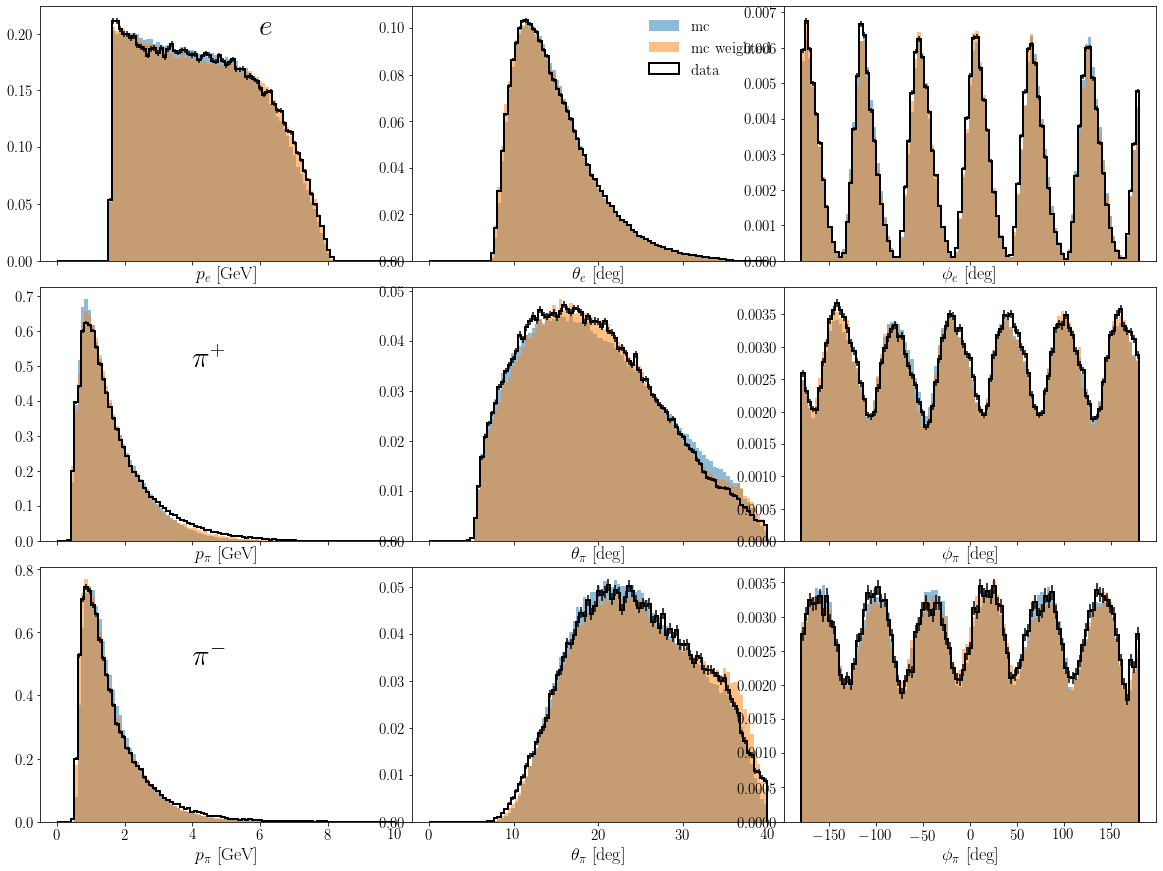

In [96]:
fig, axs = plt.subplots(3, 3, sharey=False, sharex='col', figsize=(20,15), gridspec_kw={'hspace': 0.1, 'wspace':0})
Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for i,part,query in (0, "e_","abs(h_pid) == 211"),(1,"h_","h_pid==211"),(2,"h_","h_pid==-211"):
    for j,var,mn,mx in (0,"p",0,10),(1,"th*180/3.14159",0,40),(2,"ph*180/3.14159",-180,180):
#         binning = np.linspace(mn, mx,100)
        
#         axs[i][j].hist(mc.query(query).eval(part+var),density=True,bins=binning,alpha=0.5,label='mc')
#         axs[i][j].hist(mc.query(query).eval(part+var),bins=binning,weights = mc.query(query)['weight_reco'],**plot_style_1,label='mc weighted')
#         #axs[j].hist(data.query(query)['Q2']**2,density=True,bins=binning,alpha=0.5,label='data')
#         y,binEdges = np.histogram(data.query(query).eval(part+var),bins=binning)
#         bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#         dy     = np.sqrt(y)
#         width      = (binning[1]-binning[0])
#         norm =sum(y)/len(y)*(binning[-1]-binning[0])
#         y=y/norm
#         dy/= norm
#         axs[i][j].bar(bincenters, y, width=width, yerr=dy,label='data', alpha=0.5)
        plt.sca(axs[i][j])
        weight_plot(query,part+var,mn,mx,100)
        #axs[i][j].set_title('$%2.2f<z<%2.2f$'%(ibin[0],ibin[1]),fontsize=20)
        #axs[i][j].set_xlabel(r'$Q^2$',fontsize=25)
        #axs[i][j].set_yscale('log')
        #print(query)
        
axs[0][1].legend(frameon=False,loc='best')
axs[0][0].text(6,0.2, "$e$",fontsize=30)
axs[0][0].set_xlabel("$p_e$ [GeV]")
axs[0][1].set_xlabel("$\\theta_e$ [deg]")
axs[0][2].set_xlabel("$\\phi_e$ [deg]")
axs[1][0].text(4,0.5, "$\\pi^+$",fontsize=30)
axs[1][0].set_xlabel("$p_\\pi$ [GeV]")
axs[1][1].set_xlabel("$\\theta_\\pi$ [deg]")
axs[1][2].set_xlabel("$\\phi_\\pi$ [deg]")
axs[2][0].text(4,0.5, "$\\pi^-$",fontsize=30)
axs[2][0].set_xlabel("$p_\\pi$ [GeV]")
axs[2][1].set_xlabel("$\\theta_\\pi$ [deg]")
axs[2][2].set_xlabel("$\\phi_\\pi$ [deg]")
fig.savefig("../images/base_variables.pdf")

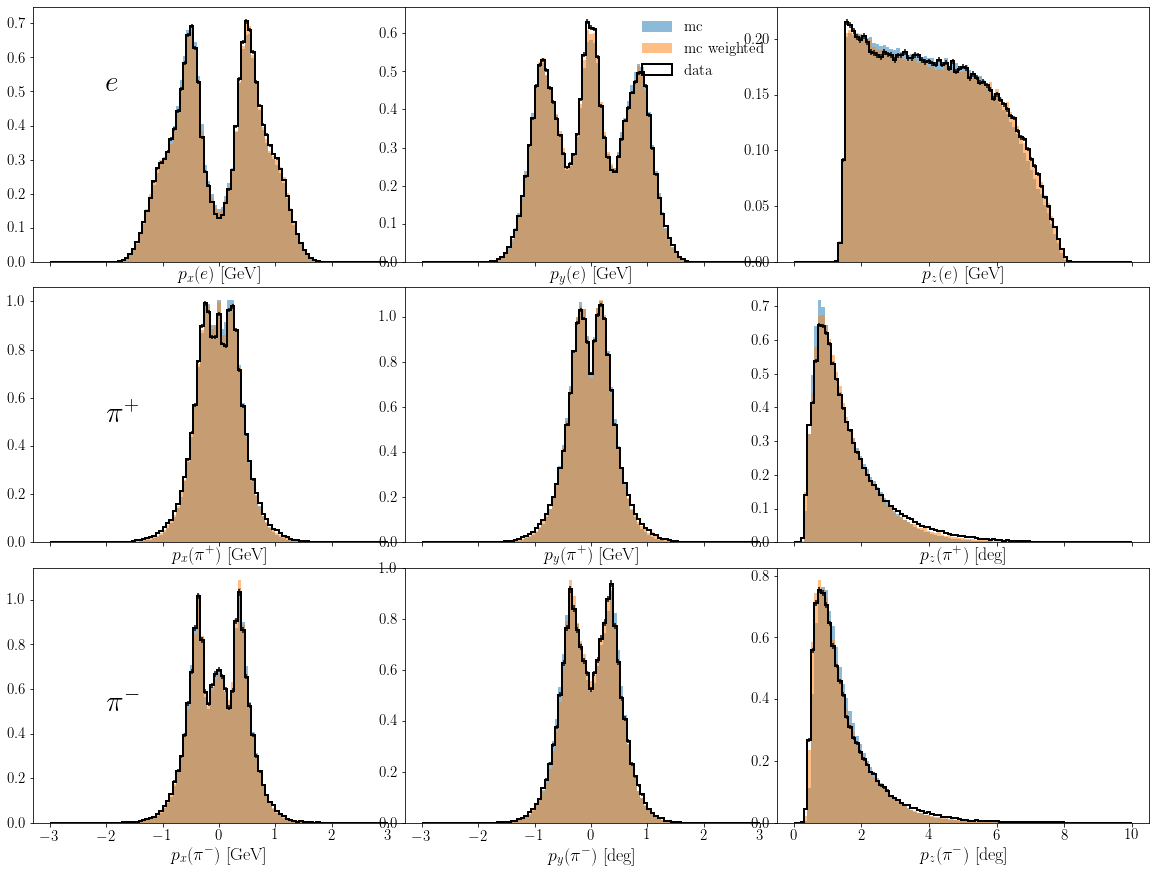

In [97]:
fig, axs = plt.subplots(3, 3, sharey=False, sharex='col', figsize=(20,15), gridspec_kw={'hspace': 0.1, 'wspace':0})
Edges = [0.0,0.2,0.4,0.6,0.8,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for i,part,query in (0, "e_","abs(h_pid) == 211"),(1,"h_","h_pid==211"),(2,"h_","h_pid==-211"):
    for j,var,mn,mx in (0,"a_p*sin(a_th)*cos(a_ph)",-3,3),(1,"a_p*sin(a_th)*sin(a_ph)",-3,3),(2,"a_p*cos(a_th)",0,10):

        plt.sca(axs[i][j])
        weight_plot(query,var.replace("a_",part),mn,mx,100)
        #axs[i][j].set_title('$%2.2f<z<%2.2f$'%(ibin[0],ibin[1]),fontsize=20)
        #axs[i][j].set_xlabel(r'$Q^2$',fontsize=25)
        #axs[i][j].set_yscale('log')
        #print(query)
        
axs[0][1].legend(frameon=False,loc='best')
axs[0][0].text(-2,0.5, "$e$",fontsize=30)
axs[0][0].set_xlabel("$p_x(e)$ [GeV]")
axs[0][1].set_xlabel("$p_y(e)$ [GeV]")
axs[0][2].set_xlabel("$p_z(e)$ [GeV]")
axs[1][0].text(-2,0.5, "$\\pi^+$",fontsize=30)
axs[1][0].set_xlabel("$p_x(\\pi^+)$ [GeV]")
axs[1][1].set_xlabel("$p_y(\\pi^+)$ [GeV]")
axs[1][2].set_xlabel("$p_z(\\pi^+)$ [deg]")
axs[2][0].text(-2,0.5, "$\\pi^-$",fontsize=30)
axs[2][0].set_xlabel("$p_x(\\pi^-)$ [GeV]")
axs[2][1].set_xlabel("$p_y(\\pi^-)$ [deg]")
axs[2][2].set_xlabel("$p_z(\\pi^-)$ [deg]")
fig.savefig("../images/base_variables_cart.pdf")